# Machine Learning and Data Mining Lab 3
## Author: Pawel Guzewicz

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import matthews_corrcoef
import time

### Loading the data

In [2]:
training_set = pd.read_csv('train.csv', sep=';')
test_set = pd.read_csv('test.csv', sep=';', names=training_set.columns.values[:-1])

In [3]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 21 columns):
age               2999 non-null int64
job               2999 non-null object
marital           2999 non-null object
education         2999 non-null object
default           2999 non-null object
housing           2999 non-null object
loan              2999 non-null object
contact           2999 non-null object
month             2999 non-null object
day_of_week       2999 non-null object
duration          2999 non-null int64
campaign          2999 non-null int64
pdays             2999 non-null int64
previous          2999 non-null int64
poutcome          2999 non-null object
emp.var.rate      2999 non-null float64
cons.price.idx    2999 non-null float64
cons.conf.idx     2999 non-null float64
euribor3m         2999 non-null float64
nr.employed       2999 non-null float64
y                 2999 non-null object
dtypes: float64(5), int64(5), object(11)
memory usage: 492.1+ KB


In [4]:
training_set.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [5]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 20 columns):
age               1120 non-null int64
job               1120 non-null object
marital           1120 non-null object
education         1120 non-null object
default           1120 non-null object
housing           1120 non-null object
loan              1120 non-null object
contact           1120 non-null object
month             1120 non-null object
day_of_week       1120 non-null object
duration          1120 non-null int64
campaign          1120 non-null int64
pdays             1120 non-null int64
previous          1120 non-null int64
poutcome          1120 non-null object
emp.var.rate      1120 non-null float64
cons.price.idx    1120 non-null float64
cons.conf.idx     1120 non-null float64
euribor3m         1120 non-null float64
nr.employed       1120 non-null float64
dtypes: float64(5), int64(5), object(10)
memory usage: 175.1+ KB


In [6]:
test_set.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,49,management,divorced,university.degree,no,no,no,cellular,jul,thu,144,5,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1
1,31,admin.,unknown,high.school,no,no,no,telephone,may,mon,182,8,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0
2,31,admin.,single,basic.9y,no,no,no,telephone,may,wed,80,1,999,1,failure,-1.8,92.893,-46.2,1.281,5099.1
3,60,admin.,married,high.school,no,yes,yes,cellular,apr,thu,482,2,999,0,nonexistent,-1.8,93.075,-47.1,1.365,5099.1
4,33,blue-collar,married,high.school,no,no,no,cellular,apr,mon,87,2,999,2,failure,-1.8,93.075,-47.1,1.405,5099.1


### Preprocessing of the data
#### Checking the features

In [7]:
merged_set = training_set.drop('y', axis=1).append(test_set)
for i, feature in enumerate(merged_set.columns.values):
    print(str(i) + ". " + feature + "\n", sorted(merged_set[feature].unique()), "\n")

0. age
 [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 85, 86, 88] 

1. job
 ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown'] 

2. marital
 ['divorced', 'married', 'single', 'unknown'] 

3. education
 ['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown'] 

4. default
 ['no', 'unknown', 'yes'] 

5. housing
 ['no', 'unknown', 'yes'] 

6. loan
 ['no', 'unknown', 'yes'] 

7. contact
 ['cellular', 'telephone'] 

8. month
 ['apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep'] 

9. day_of_week
 ['fri', 'mon', 'thu', 'tue', 'wed'] 

10. duration
 [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1

#### Feature engineering

In [8]:
# use with caution: this function has side effects on input dataframes
def transform_features(dataframes, replace_unknown, replace_nonexistent):
    new_dataframes = []

    for df in dataframes:
        # numeric features (fine): 0. age, 10. duration, 11. campaign, 12. pdays, 13. previous,
        # 15. emp.var.rate, 16. cons.price.idx, 17. cons.conf.idx, 18. euribor3m, 19. nr.employed

        # categorical features with 'unknown's: 1. job, 2. marital, 3. education, 4. default, 5.housing, 6. loan
        if replace_unknown:
            nan = 'unknown'
            for feature in ['job', 'marital', 'education', 'default', 'housing', 'loan']:
                feature_counts = df[feature].value_counts().index
                feature_count = feature_counts[0]
                if feature_count == nan:
                    feature_count = feature_counts[1]
                df[feature] = df[feature].replace(nan, feature_count)

        # categorical features with 'nonexistent's: 14. poutcome
        if replace_nonexistent:
            nan = 'nonexistent'
            poutcome_counts = df['poutcome'].value_counts().index
            poutcome_count = poutcome_counts[0]
            if poutcome_count == nan:
                poutcome_count = poutcome_counts[1]

            df['poutcome'] = df['poutcome'].replace(nan, poutcome_count)

        # binary features with 'yes/no': 4. default, 5. housing, 6.loan
        if replace_unknown:
            for feature in ['default', 'housing', 'loan']:
                df[feature] = df[feature].map({'yes': 1, 'no': 0})

        # binary features with 'cellular/telephone': 7. contact
        df['contact'] = df['contact'].map({'cellular': 1, 'telephone': 0})

        # binary features with 'failure/success': 14. poutcome
        if replace_nonexistent:
            df['poutcome'] = df['poutcome'].map({'failure': 1, 'success': 0})

        # multiclass features with order: 8. month, 9. day_of_week
        df['month'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                                       'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
        df['day_of_week'] = df['day_of_week'].map({'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7})

        # multiclass features without order: 1. job, 2. marital, 3. education, (4. default, 5.housing, 6. loan), (14. poutcome)
        features = ['job', 'marital', 'education']
        if not replace_unknown:
            features += ['default', 'housing', 'loan']
        if not replace_nonexistent:
            features += ['poutcome']
        # dummy variables for categorical features
        for feature in features:
            df = pd.concat([df, pd.get_dummies(df[feature], prefix=feature)], axis=1)
            df = df.drop(feature, axis=1)
        
        new_dataframes += [df]
    
    return new_dataframes

In [9]:
dataframes = [training_set, test_set, merged_set]
[training_set, test_set, merged_set] = transform_features(dataframes, False, False)
test_set.drop('education_illiterate', axis=1, inplace=True)
merged_set.drop('education_illiterate', axis=1, inplace=True);

#### Final check of the features

In [10]:
for i, feature in enumerate(merged_set.columns.values):
    print(str(i) + ". " + feature + "\n", sorted(merged_set[feature].unique()), "\n")

0. age
 [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 85, 86, 88] 

1. contact
 [0, 1] 

2. month
 [3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 

3. day_of_week
 [1, 2, 3, 4, 5] 

4. duration
 [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 

### Checking the distribution of the data

0    2668
1     331
Name: y, dtype: int64


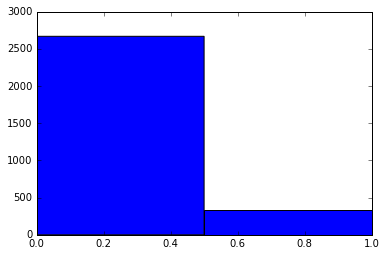

In [11]:
counts = training_set['y'].map({'yes': 1, 'no': 0})
print(counts.value_counts())
plt.hist(counts, bins = [0, 0.5, 1])
plt.figure()
plt.show()

### Oversampling

In [12]:
training_set_minority_class = training_set[training_set['y'] == 'yes']
training_set_with_oversampling = training_set
for i in range(7):
    training_set_with_oversampling = training_set_with_oversampling.append(training_set_minority_class)
training_set = training_set_with_oversampling

0    2668
1    2648
Name: y, dtype: int64


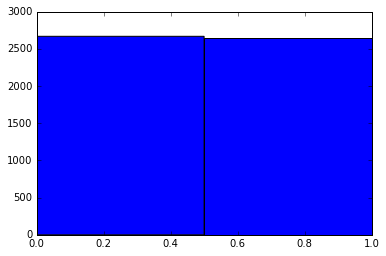

In [13]:
counts = training_set['y'].map({'yes': 1, 'no': 0})
print(counts.value_counts())
plt.hist(counts, bins = [0, 0.5, 1])
plt.figure()
plt.show()

### Undersampling

In [14]:
source_pd, target_pd = training_set.drop('y', axis=1), training_set['y'].map({'yes': 1, 'no': 0})
source_np, target_np = source_pd.values, target_pd.values

In [15]:
#size = len(target_np[target_np == 1])
#tomek = TomekLinks(ratio={1: size, 0: size}, random_state=225)
#source_np, target_np = tomek.fit_sample(source_np, target_np)

In [16]:
size = len(target_np[target_np == 1])
rus = RandomUnderSampler(ratio={1: size, 0: size}, random_state=225)
source_np, target_np = rus.fit_sample(source_np, target_np)

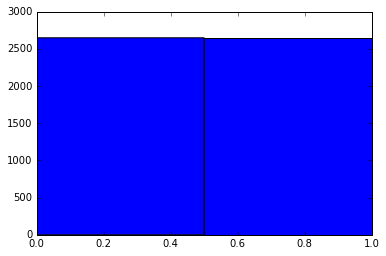

In [17]:
plt.hist(target_np, bins = [0, 0.5, 1])
plt.figure()
plt.show()

### Training model

#### Better Classifier
It is a combined clssifier. It consists of Logistic Regression, Random Forest, SVM and Neural Network. It takes the features and chooses k the most correlated ones. Then it uses those features to predict the output by each subclassifier. Finally decision is made by voting and it favours the label chosen by majority of the classifiers. Arbiter may be introduced to break the ties.

In [18]:
class BetterClassifier(BaseEstimator):
    # Credits for the function vcorrcoef go to:
    # https://waterprogramming.wordpress.com/2014/06/13/numpy-vectorized-correlation-coefficient/
    def __vcorrcoef__(self, X, y):
        Xm = np.ones(X.shape[1]) * np.reshape(np.mean(X, axis=1), (X.shape[0], 1))
        ym = np.mean(y)
        r_num = np.sum((X - Xm) * (y - ym), axis=1)
        r_den = np.sqrt(np.sum((X - Xm) ** 2, axis=1) * np.sum((y - ym) ** 2))
        r = r_num / r_den
        return r
    
    def __init__(self, k1, k2, k3, k4, use_classifiers, arbiter, verbose=False):
        if len(arbiter) > 1:
            raise Exception('wrong number of arbiters')
        if len(arbiter) == 1:
            if arbiter[0] not in use_classifiers:
                raise Exception('arbiter not from the classifiers used')
        self.arbiter = arbiter
        self.use_classifiers = use_classifiers
        self.classifier1 = LogisticRegression(random_state=300)
        self.classifier2 = RandomForestClassifier(max_depth=7, random_state=125, n_estimators=325)
        self.classifier3 = svm.SVC(kernel='linear', C=1.0, gamma=0.1, random_state=625)
        self.classifier4 = MLPClassifier(activation='logistic', solver='lbfgs', random_state=75)
        self.features1 = []
        self.features2 = []
        self.features3 = []
        self.features4 = []
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        self.k4 = k4
        self.verbose = verbose

    def fit(self, X, y):
        # compute correlations between features (columns) and target (label vector)
        correlations = self.__vcorrcoef__(X.T, y)

        # select the most correlated k
        correlations_with_numbers = zip(correlations, range(len(correlations)))
        correlations_with_numbers = sorted(correlations_with_numbers, key=lambda tup: abs(tup[0]), reverse=True)
        self.features1 = sorted(map(lambda tup: tup[1], correlations_with_numbers[:self.k1]))
        self.features2 = sorted(map(lambda tup: tup[1], correlations_with_numbers[:self.k2]))
        self.features3 = sorted(map(lambda tup: tup[1], correlations_with_numbers[:self.k3]))
        self.features4 = sorted(map(lambda tup: tup[1], correlations_with_numbers[:self.k4]))
        if self.verbose:
            print(self.features1)
            print(self.features2)
            print(self.features3)
            print(self.features4)

        if 1 in self.use_classifiers:
            self.classifier1.fit(X[:, self.features1], y)
        if 2 in self.use_classifiers:
            self.classifier2.fit(X[:, self.features2], y)
        if 3 in self.use_classifiers:
            self.classifier3.fit(X[:, self.features3], y)
        if 4 in self.use_classifiers:
            self.classifier4.fit(X[:, self.features4], y)

    def threshold(self, y, threshold=0.5):
        vfunc = np.vectorize(lambda x: 0 if x <= threshold else 1)
        return vfunc(y)

    def predict(self, X):
        prediction = np.zeros(X.shape[0])

        if 1 in self.use_classifiers:
            prediction += self.classifier1.predict(X[:, self.features1])
            if 1 in self.arbiter:
                prediction += self.classifier1.predict(X[:, self.features1])
        if 2 in self.use_classifiers:
            prediction += self.classifier2.predict(X[:, self.features2])
            if 2 in self.arbiter:
                prediction += self.classifier2.predict(X[:, self.features2])
        if 3 in self.use_classifiers:
            prediction += self.classifier3.predict(X[:, self.features3])
            if 3 in self.arbiter:
                prediction += self.classifier3.predict(X[:, self.features3])
        if 4 in self.use_classifiers:
            prediction += self.classifier4.predict(X[:, self.features4])
            if 4 in self.arbiter:
                prediction += self.classifier4.predict(X[:, self.features4])
        if self.verbose:
            print('prediction done')

        return self.threshold(prediction / (len(self.use_classifiers) + len(self.arbiter)), 0.5)

    def score(self, X, y):
        return matthews_corrcoef(self.predict(X), y)

#### Grid search and cross validation

In [19]:
#max_i = 0
#max_score = 0
#for i in [[], [1], [2], [3], [4]]:
classifier = BetterClassifier(36, 4, source_np.shape[1], 6, [2, 3, 4], [3])
cv = KFold(n_splits=5, shuffle=True, random_state=5)
scores1 = cross_val_score(classifier, source_np, target_np, cv=cv)
cv = KFold(n_splits=5, shuffle=True, random_state=25)
scores2 = cross_val_score(classifier, source_np, target_np, cv=cv)
scores = np.concatenate([scores1, scores2])
mean, std = scores.mean(), scores.std(ddof=1)
print("%s: mean: %0.8f, standard deviation: %0.8f, error: %0.8f" % (classifier.__class__.__name__, mean, std, 1 - mean))
#    if mean > max_score:
#        max_score = mean
#        max_i = i
#print(max_score, max_i)

BetterClassifier: mean: 0.64359066, standard deviation: 0.01886786, error: 0.35640934


#### Justification for the choices of parameters
Initially I chose to combine four classifiers. Different classifiers were introduced to provide robust result. Having such an ensemble, I performed grid search to find optimal parameters for each classifier, every time computing the score using 2 times 5-fold cross-validation (2x5 CV) in order to remove the bias of the choice of the training and test data (5) and bias of the split into the folds (2).
Logistic Regression classifier has been abandoned due to the poor results compared to Random Forest and negative impact on the final score on the competition. SVM has been filled with all the features to let the algorithm decide to choose the best. Parameters of Random Forset and Neural Network were obtained as a result grid search with cross validation.

### Making prediction for the test data

#### Training classifier on the whole over/undersampled training set

In [20]:
classifier.fit(source_np, target_np)

#### Computing prediction for the test set

In [21]:
test_np = test_set.values
prediction = classifier.predict(test_np)

### Preparing the submission

In [22]:
# Check for the format of submission: should contain 1 and 0 instead of "yes" and "no"
def create_csv_submission(prediction):
    submission_file_path = time.strftime("%Y%m%d_%H%M%S_submission.csv")
    with open(submission_file_path, 'w') as csvfile:
        fieldnames = ['Id', 'prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for i, elem in enumerate(prediction):
            writer.writerow({'Id': str(i + 1), 'prediction': str(elem)[0]})

#### Creating Kaggle submission file

In [23]:
create_csv_submission(prediction)